In [1]:
from tensorflow.keras import datasets

In [2]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/ZB/DL_project_2')

In [6]:
batch_size = 4
img_height = 224
img_width = 224

In [8]:
dataset_path = '/content/drive/MyDrive/ZB/DL_project_2/temp_data/Training'
train_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    # validation_split=0.2,
    # subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 84914 files belonging to 5 classes.


In [9]:
dataset_path = '/content/drive/MyDrive/ZB/DL_project_2/temp_data/Validation'
val_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    # validation_split=0.2,
    # subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 6011 files belonging to 5 classes.


In [10]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet' )

16705208/16705208 [==============================] - 2s 0us/step


In [11]:
print(len(base_model.layers))

238


In [12]:
for i in base_model.layers[200:]:
    i.trainable = True

In [13]:
inputs = Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="pred")(x)

model_Effi = tf.keras.Model(inputs, outputs)

In [14]:
model_Effi.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
history = model_Effi.fit(
                    train_x,
                    validation_data=val_x,
                    epochs=10,
                    callbacks = [early])

Epoch 1/10
21229/21229 [==============================] - 16913s 794ms/step - loss: 0.5686 - accuracy: 0.8026 - val_loss: 0.5678 - val_accuracy: 0.8426
Epoch 2/10
21229/21229 [==============================] - 1153s 54ms/step - loss: 0.2687 - accuracy: 0.9126 - val_loss: 0.5953 - val_accuracy: 0.8594
Epoch 3/10
21229/21229 [==============================] - 1147s 54ms/step - loss: 0.1803 - accuracy: 0.9429 - val_loss: 0.6075 - val_accuracy: 0.8656
Epoch 4/10
21229/21229 [==============================] - 1156s 54ms/step - loss: 0.1416 - accuracy: 0.9555 - val_loss: 0.6501 - val_accuracy: 0.8779
Epoch 5/10
21229/21229 [==============================] - 1145s 54ms/step - loss: 0.1194 - accuracy: 0.9632 - val_loss: 1.5223 - val_accuracy: 0.8286
Epoch 6/10
21229/21229 [==============================] - 1158s 55ms/step - loss: 0.1009 - accuracy: 0.9684 - val_loss: 1.0786 - val_accuracy: 0.8296
Epoch 7/10
21229/21229 [==============================] - 1154s 54ms/step - loss: 0.0908 - accurac

In [15]:
import h5py
model_Effi.save_weights('EfficientNetB0_Transer_Learning_from_200th_layer_epoch10.h5')
# model = tf.keras.models.load_weights('./EfficientNetB0_Transer_Learning_from_200th_layer_224X224')
# model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy)

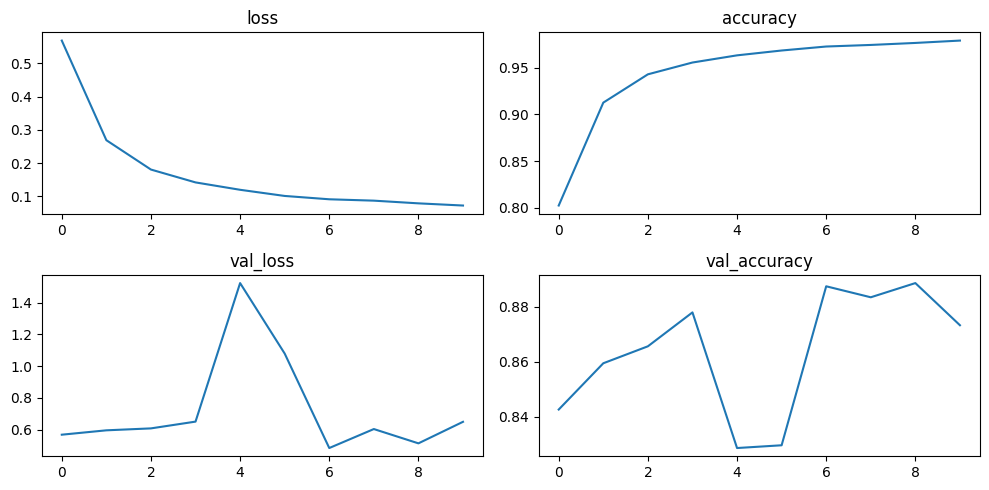

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(history.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(history.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

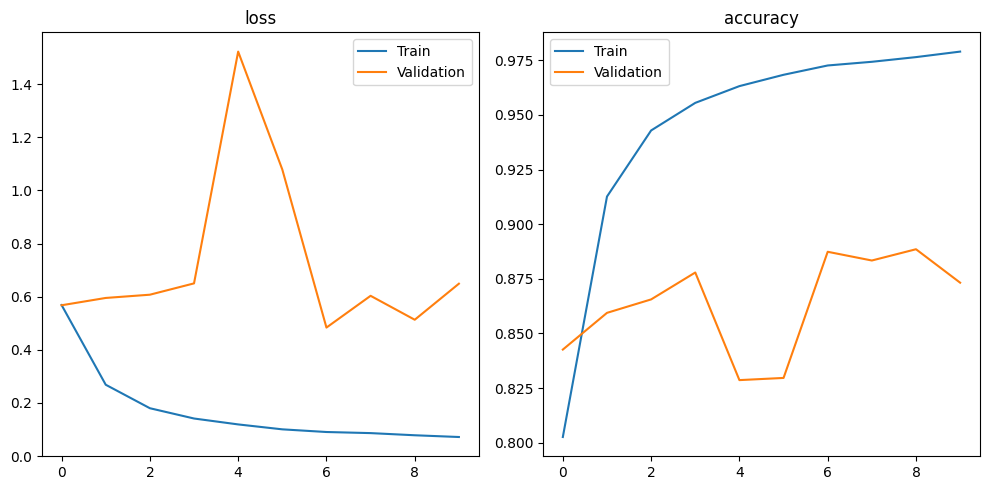

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.title('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_true = []
y_pred = []
i = 0
for x,y in val_x:
    i += 1
    y_true.extend(y)
    temp = model_Effi.predict(x)
    temp = [np.argmax(tmp) for tmp in temp]
    y_pred.extend(temp)

In [20]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

In [22]:
import pandas as pd
df = pd.DataFrame(cm)
df.head()

,0,1,2,3,4
0,0.982287,0.003221,0.006441,0.004831,0.003221
1,0.002488,0.868112,0.091717,0.000000,0.037682
2,0.005386,0.272890,0.698384,0.000000,0.023339
3,0.040060,0.022676,0.002268,0.889645,0.045351
4,0.000000,0.078910,0.010043,0.005739,0.905308


In [23]:
df.index = ['call', 'normal','sleep','smoke','yawn']
df.columns = ['call', 'normal','sleep','smoke','yawn']

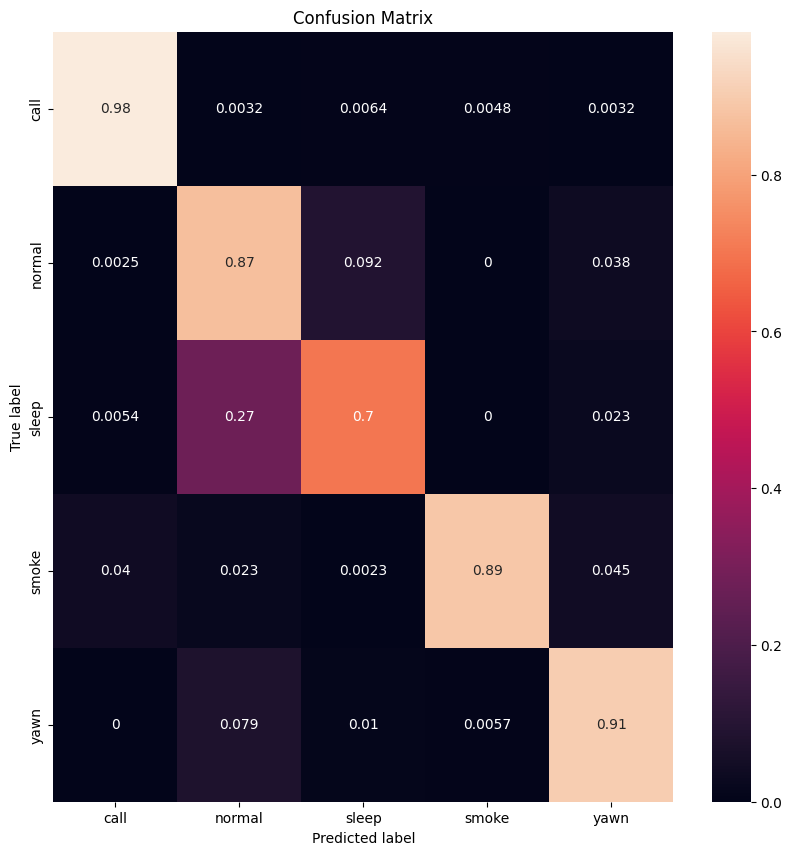

In [26]:
import seaborn as sns

fig = plt.figure(figsize = (10,10))
ax = sns.heatmap(df, annot=True)
ax.set(title = 'Confusion Matrix',
            ylabel='True label',
            xlabel='Predicted label')
fig.savefig("confusion_matrix_for_EfficientNetB0")